# Deep Learning - Lab Section : Document Classification, Recurrent Neural Networks.

Starting with as usual importing necessary libraries which we use further

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split, GridSearchCV)

#importing pytorch
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary
from torchvision.io import read_image

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop, ToTensor)

from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)
from ISLP.torch.imdb import (load_lookup, load_tensor, load_sparse, load_sequential)

from glob import glob
import json

C:\Users\Samihan Sahasrabudhe\AppData\Local\Temp\ipykernel_21208\1600179087.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 10.9.5 IMDB Document Classification
We now implement models for sentiment classification on the `IMDB`
dataset. We are using a preprocessed version of the `IMDB` dataset found in the
`keras` package. As `keras` uses `tensorflow`, a different
tensor and deep learning library, we have
converted the data to be suitable for `torch`. These data use a dictionary of size 10,000.

We have stored three different representations of the review data for this lab:

* `load_tensor()`, a sparse tensor version usable by `torch`;
* `load_sparse()`, a sparse matrix version usable by `sklearn`, since we will compare with a lasso fit;
* `load_sequential()`, a padded
version of the original sequence representation, limited to the last
500 words of each review.

In [3]:
(imdb_seq_train, imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]

c:\Users\Samihan Sahasrabudhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\ISLP\torch\imdb.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  S_test) = [torc

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468])

The datasets `imdb_seq_train` and `imdb_seq_test` are
both instances of the class `TensorDataset`. The
tensors used to construct them can be found in the `tensors` attribute, with
the first tensor  the features `X` and the second  the outcome `Y`.
We have taken the first row of features and stored it as `padded_sample`. In the preprocessing
used to form these data, sequences were padded with 0s in the beginning if they were
not long enough, hence we remove this padding by restricting to entries where
`padded_sample > 0`. We then provide the first 12 words of the sample review.

We can find these words in the `lookup` dictionary from the `ISLP.torch.imdb` module.

In [4]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

"<START> this film was just brilliant casting location scenery story direction everyone's"

For our first model, we have created a binary feature for each
of the 10,000 possible words in the dataset, with an entry of one
in the $i,j$ entry if word $j$ appears in review $i$. As most reviews
are quite short, such a feature matrix has over 98% zeros. These data
are accessed using `load_tensor()` from the `ISLP` library.

In [5]:
max_num_workers=10 # Number of workers specified.
(imdb_train, imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train, imdb_test, validation=2000, num_workers=min(6, max_num_workers), batch_size=512)

c:\Users\Samihan Sahasrabudhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\ISLP\torch\imdb.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test, X_train

We are using a two-layer model for our first model.

In [6]:
class IMDBModel(nn.Module):

    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

Now, we instantiate our model and look at a summary of that model.

In [7]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model, input_size=imdb_test.tensors[0].size(), col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

The model architecture is : three linear layers and two ReLU activation functions. The input shape is [25000, 10003], and the output shape is [25000].

The model has a total of 160,353 parameters, all of which are trainable.

The estimated total size of the model is approximately 1007.54 MB, with the input size being the largest contributor (1000.30 MB).

We’ll again use
a smaller learning rate for these data,
hence we pass an `optimizer` to the
`SimpleModule`. 
Since the reviews are classified into
positive or negative sentiment, we use
`SimpleModule.binary_classification()`. {Our use of
  `binary_classification()` instead of  `classification()` is
  due to some subtlety in how `torchmetrics.Accuracy()` works,
as well as the data type of the targets.}

In [8]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001) # Reducing the learning rate, similarly as we have done in the CNN.
imdb_module = SimpleModule.binary_classification(imdb_model, optimizer=imdb_optimizer)

Having loaded the datasets into a data module
and created a `SimpleModule`, the remaining steps
are familiar.

In [9]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True, max_epochs=30, logger=imdb_logger, callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module, datamodule=imdb_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Samihan Sahasrabudhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


The model is an instance of the IMDBModel class, which has 160,000 trainable parameters. This suggests that the model is a relatively small neural network.

The loss function used is BCEWithLogitsLoss, which is a common loss function for binary classification problems.

The estimated size of the model is 0.641 MB, which is relatively small. 

There are 6 modules in the model that are currently in training mode.

Evaluating the test error yields roughly 85% accuracy.

In [10]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8505200147628784
        test_loss           1.1805237531661987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1805237531661987, 'test_accuracy': 0.8505200147628784}]

The model achieved a test accuracy of 85.05%, which indicates that the model is able to correctly classify approximately 85.05% of the test data.

The model achieved a test loss of 1.18, which indicates the average difference between the model's predictions and the actual labels on the test data.

The model's performance on the test data is relatively good, with a high accuracy and a relatively low loss.

Increasing the model's complexity may improve its performance, but may also increase the risk of overfitting.

Though the model is good, further the model's performance on the test data may be improved by reducing overfitting, which can be achieved by techniques such as regularization, dropout, or early stopping.

### Comparison to Lasso
We now fit a lasso logistic regression model
 using `LogisticRegression()` from `sklearn`. Since `sklearn` does not recognize
the sparse tensors of `torch`, we use a sparse
matrix that is recognized by `sklearn.`

In [11]:
((X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)) = load_sparse(validation=2000, random_state=0, root='data/IMDB')

we construct a series of 50 values for the lasso reguralization parameter $\lambda$.

In [12]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1), np.log(1e-4), 50))

With `LogisticRegression()` the regularization parameter
C is specified as the inverse of $\lambda$. There are several
solvers for logistic regression; here we use `liblinear` which
works well with the sparse input format.

In [13]:
logit = LogisticRegression(penalty='l1', C=1/lam_max, solver='liblinear', warm_start=True, fit_intercept=True)

The path of 50 values takes approximately 40 seconds to run.

In [14]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

The coefficient and intercepts have an extraneous dimension which can be removed
by the `np.squeeze()`  function.

In [15]:
coefs = np.squeeze(coefs) # Removing the extraneous dimension.
intercepts = np.squeeze(intercepts)

We’ll now make a plot to compare our neural network results with the
lasso.

In [16]:
%%capture
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_), data_, color) in zip([(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)], ['Training', 'Validation', 'Test'], ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]), accuracy_, '.--', color=color, markersize=13, linewidth=2, label=data_)
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)

Notice the use of `%%capture`, which suppresses the displaying of the partially completed figure. This is useful
when making a complex figure, since the steps can be spread across two or more cells.
We now add a plot of the lasso accuracy, and display the composed figure by simply entering its name at the end of the cell.

In [17]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'], ['black', 'red'], [training_legend, valid_legend]):
        results.plot(x='epoch', y=column, label=label, marker='o', color=color, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

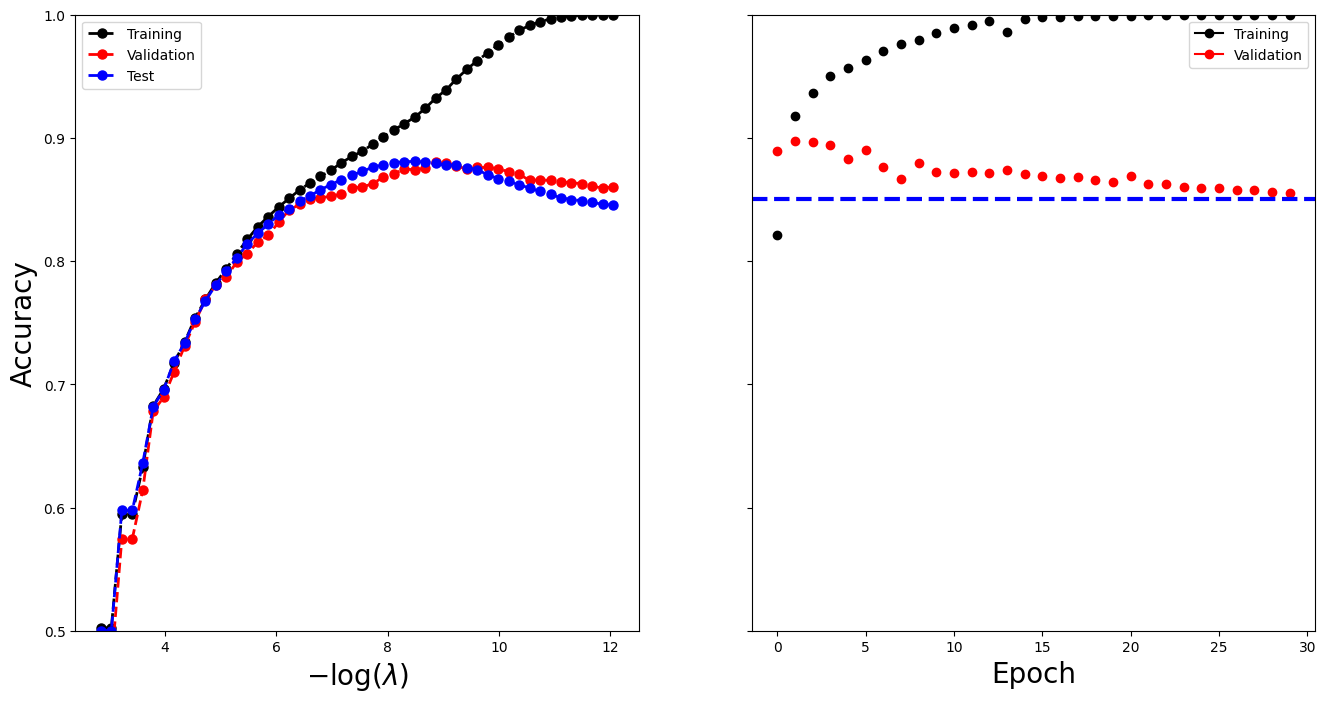

In [18]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results, axes[1], col='accuracy', ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1]);
axes[1].axhline(test_results[0]['test_accuracy'], color='blue', linestyle='--', linewidth=3)
fig

**Observations :**

The training accuracy consistently outperforms the validation and testing accuracy, especially as the number of epochs increases. This indicates a potential overfitting issue, where the model is learning the training data too well but struggles to generalize to unseen data.

The training accuracy seems to decrease slightly as log(λ) increases, suggesting that regularization is helping to control overfitting. However, the validation and testing accuracy don't show a consistent improvement. Early stopping could have been employed to prevent further overfitting.

Reducing the model's complexity or using more regularization could improve generalization.

THe models can be further improved by data augmentation, cross-validation or hyperparameter tuning

From the graphs we see that the accuracy of the lasso logistic regression peaks at about $0.88$,  as it does for  the neural network.

Once again, we end with a cleanup.

In [19]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

## Recurrent Neural Networks

### Sequential Models for Document Classification
Here we  fit a simple  LSTM RNN for sentiment prediction to
the `IMDb` movie-review data.
For an RNN we use the sequence of words in a document, taking their
order into account.
A script that details the preprocessing can be found in the
`ISLP` library. Notably, since more than 90% of the documents
had fewer than 500 words, we set the document length to 500. For
longer documents, we used the last 500 words, and for shorter
documents, we padded the front with blanks.

In [20]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train, imdb_seq_test, validation=2000, batch_size=300, num_workers=min(6, max_num_workers))

The first layer of the RNN is an embedding layer of size 32, which will be
learned during  training. This layer one-hot encodes  each document
as a matrix of dimension $500 \times 10,003$, and then maps these
$10,003$ dimensions down to $32$. {The extra 3 dimensions
correspond to commonly occurring non-word entries in the reviews.}
 Since each word is represented by an
integer, this is effectively achieved by the creation of an embedding
matrix of size $10,003\times 32$; each of the 500 integers in the
document are then mapped to the appropriate 32 real numbers by
indexing the appropriate rows of this matrix.

The second  layer is an LSTM with 32 units, and the output
layer is a single logit for the binary classification task.
In the last line of the `forward()` method below,
we take the last 32-dimensional output of the LSTM and map it to our response.

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, batch_first=True)
        self.dense = nn.Linear(32, 1)
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

We instantiate and take a look at the summary of the model, using the
first 10 documents.

In [22]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,
        input_data=imdb_seq_train.tensors[0][:10],
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

**Input:** The model takes an input of shape [10, 500], meaning it processes 10 sequences, each with 500 elements.

**Output:** The model produces an output of shape [10], suggesting that it predicts 10 values for each input sequence.

**Layers:** 

An Embedding layer : This layer converts the input sequences into a numerical representation.

An LSTM layer : This layer processes the sequential data and captures dependencies.

A Linear layer : This layer maps the LSTM output to the final prediction.

#

The model has a total of 328,577 trainable parameters, which are learned during training.

The estimated total size of the model is 53.87 MB, which includes the input data, model parameters, and intermediate calculations.

In [23]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

In [24]:
lstm_trainer = Trainer(deterministic=True, max_epochs=20, logger=lstm_logger, callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module, datamodule=imdb_seq_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


The rest is now similar to other networks we have fit. We
track the test performance as the network is fit, and see that it attains 84% accuracy.

In [25]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8436800241470337
        test_loss            0.839174211025238
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.839174211025238, 'test_accuracy': 0.8436800241470337}]

Test Accuracy : 0.83796 - This represents the percentage of correct predictions made by the model on the test data.
It suggests that the model achieved a relatively high accuracy of 83.79%.

Test Loss : 0.71159 - This is a measure of the model's error on the test data. A lower loss value generally indicates better performance.

the model appears to have performed well on the test dataset, achieving a high accuracy and a relatively low loss.

Again it could be further improved by hyperparameter tunning.

We once again show the learning progress, followed by cleanup.

(0.5, 1.0)

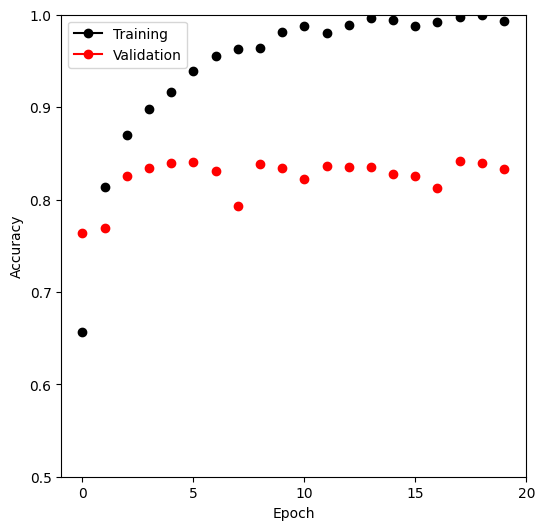

In [26]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])

Observations : 

The training accuracy steadily increases and eventually surpasses the validation accuracy. This indicates that the model is learning the training data too well but struggling to generalize to unseen data.

The model might be too complex for the given dataset, leading to overfitting. Reducing the model's complexity or using more regularization could help.

#
#
How we can improve : 

Trying different regularization techniques (e.g., L1, L2) or adjust the regularization parameter to control overfitting.

Experiment with other hyperparameters (e.g., learning rate, batch size) to optimize performance.

Implementing early stopping to prevent overfitting by monitoring the validation accuracy and stopping training when it starts to decrease.

We are deleting as usual.

In [27]:
del(lstm_model,
    lstm_trainer,
    lstm_logger,
    imdb_seq_dm,
    imdb_seq_train,
    imdb_seq_test)

### Time Series Prediction
We now show how to fit the models for time series prediction.
We first load and standardize the data.

In [28]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler( with_mean=True, with_std=True).fit_transform(NYSE[cols]), columns=NYSE[cols].columns, index=NYSE.index)

Next we set up the lagged versions of the data, dropping
any rows with missing values using the `dropna()`  method.

In [29]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

Finally, we extract the response, training indicator, and drop the current day’s `DJ_return` and
`log_volatility` to predict only from previous day’s data.

In [30]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

We first fit a simple linear model and compute the $R^2$ on the test data using
the `score()`  method.

In [31]:
M = LinearRegression() #Simple linear regression model.
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.41289129385625223

The R2 score of 0.4128 suggests that the model is able to capture a significant portion of the variability in the data. However, it also means that a considerable amount of variation remains unexplained. 41.29% is not a bad score but it alse tells that there is potential for improvement. 

But we have studied earlier that the benchmark for R2 score can vary from case to case. In some cases R2 score of 0.4128 might be considered as an excellent score. 

We refit this model, including the factor variable `day_of_week`.
For a categorical series in `pandas`, we can form the indicators
using the `get_dummies()`  method.

In [32]:
X_day = pd.merge(X, pd.get_dummies(NYSE['day_of_week']), on='date')

 Note that we do not have
to reinstantiate the linear regression model
as its `fit()` method accepts a design matrix and a response directly.

In [33]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.4595563133053274

This model achieves an $R^2$ of about 46%. 

R2 score increased when we include the factor variable 'day_of week'.  Which tells us that that variable also explains the variance significantly.

To fit the RNN, we must reshape the data, as it will expect 5 lagged
versions of each feature as indicated by the  `input_shape` argument
to the layer `nn.RNN()`  below. We first
ensure the columns of  our data frame are such that a reshaped
matrix will have the variables correctly lagged. We use the
`reindex()`  method to do this.

For an input shape `(5,3)`, each row represents a lagged version of the three variables.
The `nn.RNN()` layer also expects the first row of each
observation to be earliest in time, so we must reverse the current order.  Hence we loop over
`range(5,0,-1)` below, which is
an example of using a  `slice()`  to index
iterable objects. The general notation is `start:end:step`.

In [34]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

We now reshape the data.

In [35]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

By specifying the first size as -1, `numpy.reshape()` deduces its size based on the remaining arguments.

Now we are ready to proceed with the RNN, which uses 12 hidden units, and  10%
dropout.
After passing through the RNN,  we extract the final time point as `val[:,-1]`
in `forward()` below. This gets passed through a 10% dropout and then flattened through
a linear layer.

In [36]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3, 12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

We  fit the model in a similar fashion to previous networks. We
supply the `fit` function with test data as validation data, so that when
we monitor its progress and plot the history function we can see the
progress on the test data. Of course we should not use this as a basis for
early stopping, since then the test performance would be biased.

We form the training dataset similar to
our `Hitters` example.

In [37]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

C:\Users\Samihan Sahasrabudhe\AppData\Local\Temp\ipykernel_21208\2100042546.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))
C:\Users\Samihan Sahasrabudhe\AppData\Local\Temp\ipykernel_21208\2100042546.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))


Following our usual pattern, we inspect the summary.

In [38]:
summary(nyse_model, input_data=X_rnn_t, col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

**Input :** The model takes an input of shape [1770, 5, 3], meaning it processes 1770 sequences, each with 5 elements of 3 features.

**Output :** The model produces an output of shape [1770], suggesting that it predicts a single value for each input sequence.

**Layers :** 

An RNN layer : This layer processes the sequential data and captures dependencies.

A Dropout layer : This layer is used for regularization to prevent overfitting.

A Linear layer : This layer maps the RNN output to the final prediction.


**Parameters :** The model has a total of 217 trainable parameters, which are learned during training.

**Memory :** The estimated total size of the model is 0.97 MB, which includes the input data, model parameters, and intermediate calculations.

We again put the two datasets into a data module, with a
batch size of 64.

In [39]:
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)

We run some data through our model to be sure the sizes match up correctly.

In [40]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


We follow our previous example for setting up a trainer for a
regression problem, requesting the $R^2$ metric
to be be computed at each epoch.

In [41]:
nyse_optimizer = RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(nyse_model, optimizer=nyse_optimizer, metrics={'r2':R2Score()})

Fitting the model should by now be familiar.
The results on the test data are very similar to the linear AR model.

In [42]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Samihan Sahasrabudhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6198158264160156
         test_r2            0.41176456212997437
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6198158264160156, 'test_r2': 0.41176456212997437}]

**Observations :**

Trainable parameters are 217, indiacates that it is not a big network.

We observe test_loss of 61.98% which is a higher loss percentage. Indicating the model can be improved.

R2 score is 41.17% which seems a good score. But looking at the test_loss, we can say that for this perticular model the R2 score of around 41-42% is not sufficietly good score. 

Model can be further improved by data augmentation.

We could also fit a model without the `nn.RNN()` layer by just
using a `nn.Flatten()` layer instead. This would be a nonlinear AR model. If in addition we excluded the 
hidden layer, this would be equivalent to our earlier linear AR model.  

Instead we will fit a nonlinear AR model using the feature set `X_day` that includes the `day_of_week` indicators.
To do so, we
must first create our test and training datasets and a corresponding
data module. This may seem a little burdensome, but is part of the
general pipeline for `torch`.

In [43]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                   np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

Creating a data module follows a familiar pattern.

In [44]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)

We build a `NonLinearARModel()` that takes as input the 20 features and a hidden layer  with 32 units. The remaining steps are familiar.

In [45]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))

In [46]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                           lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                        optimizer=nl_optimizer,
                                        metrics={'r2':R2Score()})

We continue with the usual training steps, fit the model,
and evaluate the test error. We see the test $R^2$ is a slight improvement over the linear AR model that also includes `day_of_week`.

In [47]:
nl_trainer = Trainer(deterministic=True,
                         max_epochs=20,
                         callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | NonLinearARModel | 705    | train
1 | loss  | MSELoss          | 0      | train
---------------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5684899091720581
         test_r2            0.4604753255844116
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5684899091720581, 'test_r2': 0.4604753255844116}]

**Observations :**

Trainable parameters are 701, which are much increased as compared to the previous fit. Indicating one variable can also make a significant difference.

Here, R2 score is increased recognizably as we included the feature 'day_of_week' during model fitting. Which indicates that that variable explains a lot about target variable.

We observe that the test_loss is also decreased from around 60-61% to 55-56% when we included the variable.

In conclusion, data can be better fitted in the neural network when all the vaiables which can tell about the target variable are included. In some cases, excess of information may also lead to overfitting. But it could be controlled by various methods to control overfitting.